![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/logo_MCV_W.png)

# **PyTorch Lightning**
### **PyTorch Lightning is an open-source Python library that provides a high-level interface for PyTorch, a popular deep learning framework.**
---
https://pytorch-lightning.readthedocs.io/en/latest/
---

In this lesson, we learn to use the amazing library **PyTorch Lightning**. It's a great way to organize. your PyTorch code and get many great features and added benefits. We'll be doing the following in this guide:
1. Setup and Install Lightning
2. Organzing our code into the Lightning structure/design philosophy
3. Automatic Batch Selection
4. Automatic Learning Rate Selection
5. Training using Lightning
6. Tensorboard logs
7. Callbacks - Early Stopping,  Checkpoints and using Lightning Bolts Metrics
8. Saving and Loading Models from checkpoints
9. Saving as Torchscript for Production Deployment
10. Inferences
11. Multiple GPU Training
12. Training on TPUs
13. Profiler for finding Bottlenecks in Training
14. 16-Bit GPU Training

## **1. Setup and Install Lightning**

In [1]:
# First we install PyTorch Lightning and TorchMetrics
!pip install pytorch-lightning --quiet
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 18.3 MB/s eta 0:00:00


In [2]:
# Import all packages we'll be using

import os
import torch
import torchmetrics
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from PIL import Image

#### **Download our datasets**

In [3]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
From (redirected): https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk&confirm=t&uuid=66cb1a56-4912-48bb-892b-52efb1d11a97
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:09<00:00, 87.0MB/s]


## **Setup our Dataloaders**

In [4]:
class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)


# Set directory paths for our files
train_dir = './train'
test_dir = './test1'

# Get files in our directories
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# Create our transforms
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

# Create our train and test dataset objects
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

# Split into our train and validation
train, val = torch.utils.data.random_split(train,[20000,5000])

#train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
#val_loader = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

## **2. Organzing our code into the Lightning structure/design philosophy**

In [5]:
class LitModel(pl.LightningModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.conv1 = nn.Sequential(nn.Conv2d(3,16,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(32,64,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5,256), nn.ReLU(), nn.Linear(256,128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128,2),)

    def train_dataloader(self):
        # transforms
        return torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

    def cross_entropy_loss(self, logits, labels):
      return F.nll_loss(logits, labels)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output,label)
        self.log('train_loss', loss)
        return {'loss': loss, 'log': self.log}

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_loss', val_loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1)

## **3. Automatic Batch Selection**

In [6]:
model = LitModel(batch_size = 32)

trainer = pl.Trainer(auto_scale_batch_size=True)
# trainer = pl.Trainer(auto_scale_batch_size='binsearch')

trainer.tune(model)

TypeError: Trainer.__init__() got an unexpected keyword argument 'auto_scale_batch_size'

## **4. Automatic Learning Rate Selection**

Edit the Lightning Module as shown below. Note we've added in new lines at Line 5 to 8.

In [7]:
class LitModel(pl.LightningModule):
    def __init__(self, learning_rate, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate #
        self.accuracy = torchmetrics.Accuracy() #
        self.train_acc = torchmetrics.Accuracy() #
        self.valid_acc = torchmetrics.Accuracy() #
        self.conv1 = nn.Sequential(nn.Conv2d(3,16,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(32,64,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5,256), nn.ReLU(), nn.Linear(256,128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128,2),)

    def train_dataloader(self):
        # transforms
        return torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

    def cross_entropy_loss(self, logits, labels):
      return F.nll_loss(logits, labels)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output,label)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.accuracy(output, label))
        return {'loss': loss, 'log': self.log}

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy.compute())

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_acc_step', self.accuracy(val_output, val_label))
        self.log('val_loss', val_loss)

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.accuracy.compute())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=(self.learning_rate))
        return optimizer

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1)

### **Implement our Automatic Learning Rate Tuner**

In [8]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model = LitModel(batch_size = 32, learning_rate=0.001)

# Learning Rate Logger
trainer = pl.Trainer(gpus=1, auto_lr_find=True)

# Results can be found in
trainer.tune(model)

TypeError: Accuracy.__new__() missing 1 required positional argument: 'task'

### **Visualize the LR vs Loss Plot**

The figure produced by lr_finder.plot() should look something like the figure below. It is recommended to not pick the learning rate that achieves the lowest loss, but instead something in the middle of the sharpest downward slope (red point). This is the point returned py lr_finder.suggestion().

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/lr_find_temp_model_fd9b9087-0e6d-4d83-86e3-592f9d46070a.ckpt


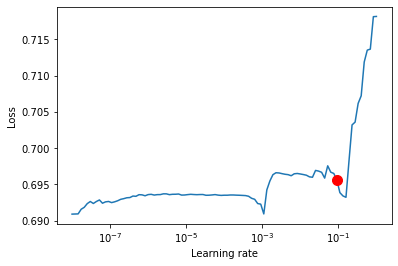

In [ ]:
lr_finder = trainer.tuner.lr_find(model)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

## **5. Train Model with learned Batch Size and Learning Rate**

The learning rate and batch size stored in `/content/lr_find_temp_model.ckpt`  and `/content/scale_batch_size_temp_model.ckpt` respectively, will be used over the learning rate set and batch sizes we set.


In [9]:
# init model
model = LitModel(batch_size = 32, learning_rate=0.001)

# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=10)

# Train the model ⚡
trainer.fit(model)

TypeError: Accuracy.__new__() missing 1 required positional argument: 'task'

## **Tensorboard logs**

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## **6. Using Callbacks - Early Stopping & Checkpointing**

**Early Stopping** -  early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent.

![](https://cdn-images-1.medium.com/max/920/1*iAK5uMoOlX1gZu-cSh1nZw.png)

**Model Checkpoint** - ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

In [ ]:
# Setup Early Stopping
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    strict = False,
    verbose = False,
    mode = 'min'
)

In [ ]:
# Setup Model Checkpoint
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='models/',
    filename='sample-catsvsdogs-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,# We save the top 3 models
    mode='min',
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Checkpoint directory models/ exists and is not empty.
  warnings.warn(*args, **kwargs)


In [ ]:
# We can even use some custom callbacks
class MyPrintingCallback(pl.callbacks.base.Callback):

    def on_init_start(self, trainer):
        print('Starting to init trainer!')

    def on_init_end(self, trainer):
        print('trainer is init now')

    def on_train_end(self, trainer, pl_module):
        print('do something when training ends')

### **Train with our Callbacks**

In [ ]:
# init model
model = LitModel(batch_size = 32, learning_rate=0.001)

# Initialize a trainer
trainer = pl.Trainer(
    gpus=1,
    max_epochs=10,
    progress_bar_refresh_rate=10,
    callbacks=[EarlyStopping('val_loss'), checkpoint_callback, MyPrintingCallback()]
)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | accuracy  | Accuracy   | 0     
1 | train_acc | Accuracy   | 0     
2 | valid_acc | Accuracy   | 0     
3 | conv1     | Sequential | 448   
4 | conv2     | Sequential | 4.6 K 
5 | conv3     | Sequential | 18.5 K
6 | fc1       | Sequential | 442 K 
7 | fc2       | Sequential | 258   
-----------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)


Starting to init trainer!
trainer is init now


do something when training ends



In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## **8. Restore from Checkpoints**

In [ ]:
# Get path of best model
checkpoint_callback.best_model_path

'/content/models/sample-catsvsdogs-epoch=09-val_loss=0.50.ckpt'

### **Load and run inference using the best checkpoint model**

In [ ]:
#loading the best checkpoints to model
pretrained_model = LitModel.load_from_checkpoint(batch_size = 32, learning_rate=0.001, checkpoint_path = checkpoint_callback.best_model_path)
pretrained_model = pretrained_model.to("cuda")
pretrained_model.eval()
pretrained_model.freeze()

## **9. Save our Model for Production Deployments**

**Exporting to TorchScript**

TorchScript allows you to serialize your models in a way that it can be loaded in non-Python environments. The LightningModule has a handy method to_torchscript() that returns a scripted module which you can save or directly use.

In [ ]:
model = LitModel.load_from_checkpoint(batch_size = 32, learning_rate=0.001, checkpoint_path = checkpoint_callback.best_model_path)

script = model.to_torchscript()

# save for use in production environment
torch.jit.save(script, "model.pt")

## **10. Run inference on 32 images from our test data loder**

In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

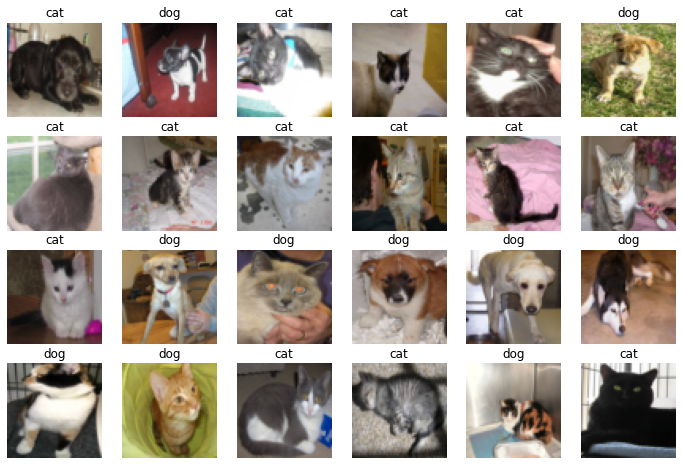

In [ ]:
samples, _ = iter(val_loader).next()
samples = samples.to('cuda')

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = pretrained_model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

## **11. Multi-GPU Training**

To train on CPU/GPU/TPU without changing your code, we need to build a few good habits :)

Delete all `.cuda()` or `.to()` calls.

**Synchronize validation and test logging**

When running in distributed mode, we have to ensure that the validation and test step logging calls are synchronized across processes. This is done by adding sync_dist=True to all self.log calls in the validation and test step. This ensures that each GPU worker has the same behaviour when tracking model checkpoints, which is important for later downstream tasks such as testing the best checkpoint across all workers.

Note if you use any built in metrics or custom metrics that use the Metrics API, these do not need to be updated and are automatically handled for you.

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        # Add sync_dist=True to sync logging across all GPU workers
        self.log('validation_loss', loss, on_step=True, on_epoch=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        # Add sync_dist=True to sync logging across all GPU workers
        self.log('test_loss', loss, on_step=True, on_epoch=True, sync_dist=True)

There are other good practices that we don't use here, but they acn be found ehre - https://pytorch-lightning.readthedocs.io/en/latest/advanced/multi_gpu.html

In [ ]:
class LitModel_mGPU(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.accuracy = torchmetrics.Accuracy()
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.conv1 = nn.Sequential(nn.Conv2d(3,16,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(32,64,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5,256), nn.ReLU(), nn.Linear(256,128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128,2),)

    def train_dataloader(self):
        # transforms
        return torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

    def cross_entropy_loss(self, logits, labels):
      return F.nll_loss(logits, labels)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output,label)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.accuracy(output, label))
        return {'loss': loss, 'log': self.log}

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy.compute())

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_loss', val_loss, on_step=True, on_epoch=True, sync_dist=True)

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.accuracy.compute())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
        return optimizer

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1)

###**Select GPU devices**
You can select the GPU devices using ranges, a list of indices or a string containing a comma separated list of GPU ids:

In [ ]:
# DEFAULT (int) specifies how many GPUs to use per node
#pl.Trainer(gpus=k)

# Above is equivalent to
#pl.Trainer(gpus=list(range(k)))

# Specify which GPUs to use (don't use when running on cluster)
#pl.Trainer(gpus=[0, 1])

# Equivalent using a string
#pl.Trainer(gpus='0, 1')

# To use all available GPUs put -1 or '-1'
# equivalent to list(range(torch.cuda.device_count()))
#pl.Trainer(gpus=-1)

#### **Note: In Colab we only have one GPU so this won't speed thigns up here**

In [ ]:
# init model
model = LitModel_mGPU()

# Initialize a trainer
trainer = pl.Trainer(
    gpus=1,
    max_epochs=10,
    progress_bar_refresh_rate=10,
    callbacks=[EarlyStopping('val_loss'), checkpoint_callback, MyPrintingCallback()]
)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | accuracy  | Accuracy   | 0     
1 | train_acc | Accuracy   | 0     
2 | valid_acc | Accuracy   | 0     
3 | conv1     | Sequential | 448   
4 | conv2     | Sequential | 4.6 K 
5 | conv3     | Sequential | 18.5 K
6 | fc1       | Sequential | 442 K 
7 | fc2       | Sequential | 258   
-----------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)


Starting to init trainer!
trainer is init now


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/step_result.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


## **12. Profiler - Performance and Bottleneck Profiler**

In [ ]:
# init model
model = LitModel_mGPU()

# Initialize a trainer
trainer = pl.Trainer(
    gpus=1,
    max_epochs=1,
    progress_bar_refresh_rate=10,
    profiler="simple"
)

trainer.fit(model)

MisconfigurationException: ignored

## **13. Training on TPUs**

**Tensor Processing Unit** is an AI accelerator application-specific integrated circuit developed by Google specifically for neural network machine learning.

**TPU Terminology**

A TPU is a Tensor processing unit. Each TPU has 8 cores where each core is optimized for 128x128 matrix multiplies. In general, a single TPU is about as fast as 5 V100 GPUs!

A TPU pod hosts many TPUs on it. Currently, TPU pod v2 has 2048 cores! You can request a full pod from Google cloud or a “slice” which gives you some subset of those 2048 cores.

### **Steps to Train on TPU**

1. Change runtime to TPU
2. Install PyTorch TPU
3. Re-install PyTorch Lightning and TorchMetrics (if needed) as therunetime has been reset.

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
!pip install pytorch-lightning --quiet
!pip install torchmetrics

A
     |████████████████████████████████| 144.6MB 66kB/s 
     |████████████████████████████████| 61kB 2.8MB/s 
ERROR: earthengine-api 0.1.260 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 1.8.0 which is incompatible.
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
     |████████████████████████████████| 808kB 5.0MB/s 
     |████████████████████████████████| 112kB 11.4MB/s 
     |████████████████████████████████| 276kB 10.8MB/s 
     |████████████████████████████████| 829kB 20.0MB/s 
     |████████████████████████████████| 645kB 25.4MB/s 
     |████████████████████████████████| 1.3MB 34.6MB/s 
     |████████████████████████████████| 296kB 38.6MB/s 
     |████████████████████████████████| 143kB 36.6MB/s 
ERROR: earthengine-api 0.1.260 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-

In [ ]:
# Import all packages we'll be using

import os
import torch
import torchmetrics
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
#from pytorch_lightning.metrics import functional as FM
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image

!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)


# Set directory paths for our files
train_dir = './train'
test_dir = './test1'

# Get files in our directories
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

# Create our train and test dataset objects
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

train, val = torch.utils.data.random_split(train,[20000,5000])

train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

In [ ]:
class LitModel_mGPU(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.accuracy = torchmetrics.Accuracy()
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.conv1 = nn.Sequential(nn.Conv2d(3,16,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(32,64,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5,256), nn.ReLU(), nn.Linear(256,128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128,2),)

    def train_dataloader(self):
        # transforms
        return torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

    def cross_entropy_loss(self, logits, labels):
      return F.nll_loss(logits, labels)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output,label)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.accuracy(output, label))
        return {'loss': loss, 'log': self.log}

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy.compute())

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_loss', val_loss, on_step=True, on_epoch=True, sync_dist=True)

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.accuracy.compute())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
        return optimizer

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1)

In [ ]:
# init model
model = LitModel_mGPU()

# Initialize a trainer
trainer = pl.Trainer(
    tpu_cores=8,
    max_epochs=1,
    progress_bar_refresh_rate=10,
)

trainer.fit(model)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores

  | Name      | Type       | Params
-----------------------------------------
0 | accuracy  | Accuracy   | 0     
1 | train_acc | Accuracy   | 0     
2 | valid_acc | Accuracy   | 0     
3 | conv1     | Sequential | 448   
4 | conv2     | Sequential | 4.6 K 
5 | conv3     | Sequential | 18.5 K
6 | fc1       | Sequential | 442 K 
7 | fc2       | Sequential | 258   
-----------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which m

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: cleaning up ddp environment...
  warnings.warn(*args, **kwargs)
